### Use the ensemble model build previously to predict the labels of the test data, then select the best training data to use via pseudo labeling.

In [1]:
import theano
from theano.sandbox import cuda
cuda.use('gpu0')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
IMPORT_DIR = '/home/ubuntu/nbs'
%cd $IMPORT_DIR

/home/ubuntu/nbs


In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import daveutils
from daveutils import *
import davenet
from davenet import *
import my_cv_modeler
from my_cv_modeler import *

Using Theano backend.


In [441]:
ALL_DATA_DIR = '/home/ubuntu/'
DATA_HOME_DIR = ALL_DATA_DIR+'statefarm/'
TRAIN_DIR = DATA_HOME_DIR+'train/'
MONKEY_DIR = DATA_HOME_DIR+'monkey/'
VALID_DIR = DATA_HOME_DIR+'valid/'
SAMPLE_DIR = DATA_HOME_DIR+'sample/'
MODELS_DIR = DATA_HOME_DIR+'models/'
RESULTS_DIR = DATA_HOME_DIR+'results/'


In [5]:
vgg = Dave16()

In [6]:
model = vgg.model

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [8]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [9]:
%cd $DATA_HOME_DIR

/home/ubuntu/statefarm


In [10]:
top_hat_model = read_model(4, cross='old') 

In [11]:
top_hat_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 25088)         0           flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 128)           3211392     dropout_3[0][0]                  
___________________________________________________________________________________________

In [12]:
conv_model = Sequential(conv_layers)


In [13]:
def add_bn_layers(p, model, top):
    new_model = model
    new_model.add(MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]))
    new_model.add(Flatten())
    new_model.add(Dropout(p/2))
    new_model.add(Dense(128, activation='relu'))
    
    #new_model.layers[len(new_model.layers)].set_weights(top.layers[3].get_weights())
    
    new_model.add(BatchNormalization())
    new_model.add(Dropout(p/2))
    new_model.add(Dense(128, activation='relu'))
    
    #new_model.layers[len(new_model.layers)].set_weights(top.layers[6].get_weights())
    
    new_model.add(BatchNormalization())
    new_model.add(Dropout(p))
    new_model.add(Dense(10, activation='softmax'))  
    
    #new_model.layers[len(new_model.layers)].set_weights(top.layers[9].get_weights())
    return new_model

In [14]:
full_model = add_bn_layers(0.8, conv_model, top_hat_model)

In [15]:
#Alternative Method for setting the top_hat weights
full_model.layers[last_conv_idx+3+1].set_weights(top_hat_model.layers[3].get_weights())
full_model.layers[last_conv_idx+6+1].set_weights(top_hat_model.layers[6].get_weights())
full_model.layers[last_conv_idx+9+1].set_weights(top_hat_model.layers[9].get_weights())

In [16]:
del conv_model
#full_model.summary()

In [17]:
full_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
DATA_HOME_DIR = ALL_DATA_DIR+'statefarm/'
#TEST_DIR = DATA_HOME_DIR + 'test'
%cd $DATA_HOME_DIR

/home/ubuntu/statefarm


In [19]:
test_datagen = ImageDataGenerator() #rescale=1./255

In [20]:
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical')

Found 60000 images belonging to 1 classes.


In [21]:
#predict_generator(self, generator, val_samples, max_q_size=10, nb_worker=1, pickle_safe=False)
test_preds = full_model.predict_generator(test_generator, 6000)

In [22]:
max_test_probs = np.array([np.amax(i) for i in test_preds])
max_test_probs[:5]


array([ 1.,  1.,  1.,  1.,  1.], dtype=float32)

In [23]:
cutoff = 0.9999
row_truth = np.array([ np.greater(i,cutoff) for i in max_test_probs.T])
row_truth[:5]

array([ True,  True,  True,  True,  True], dtype=bool)

In [24]:
good_rows = np.array(np.where(row_truth))
len(good_rows.T)

5829

In [25]:
100*len(good_rows.T)/len(test_preds)

97.15

Clearly using only model #4 is overly confident.  Let's try ensemble predictions.

In [26]:
del full_model

In [27]:
del top_hat_model

In [28]:
conv_model = Sequential(conv_layers)

In [29]:
folds = 5
models = []
for i in range(folds):
    models.append(read_model(i+1, 'old')) #read_model(index, cross='')


In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
nimages = 600#00

In [43]:
batches = 0
batch_size = 1
preds = []
for X_batch in test_datagen.flow_from_directory('test', target_size=(224, 224), batch_size=batch_size, \
                            class_mode=None, shuffle=False, save_to_dir='test', save_prefix='rs', save_format='png'):    
    #(X_batch,boo) = X_batch
    #print("Shape X_batch = ",X_batch.shape)
    feat_x = conv_model.predict(X_batch,batch_size=batch_size, verbose=0) #predict_on_batch(self, x)
    #print("Shape feat_x = ",feat_x.shape)
    pred_x = []
    for i in range(folds):
        pred = models[i].predict(feat_x,batch_size=batch_size, verbose=0)[0]
        pred_x.append(pred)
        #print(pred[0])
        #print(len(pred_x))
        #print("Len(models[i].layers))",len(models[i].layers))
    #print(batches)
    preds.append(merge_several_folds_mean(pred_x, folds))
    #print(np.array(preds).shape)
    batches += 1
    if batches >= nimages / batch_size:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
len(preds)
#preds[:5]

Found 60000 images belonging to 1 classes.


600

In [44]:
max_test_probs = np.array([np.amax(i) for i in preds])
max_test_probs[5:15]

array([ 0.807 ,  0.913 ,  0.6475,  0.4802,  0.9999])

In [45]:
row_truth = np.array([ np.greater(i,cutoff) for i in max_test_probs.T])

In [47]:
good_rows = np.array(np.where(row_truth))
100*len(good_rows.T)/len(test_preds)

0.43333333333333335

In [48]:
np.amax(max_test_probs)

0.99999904632568359

In [ ]:
test_pseudo_labels = np.array([np.argmax(i) for i in preds])
np.max(test_pseudo_labels)

In [49]:
cutoff = 0.99

In [226]:
#from ipywidgets import FloatProgress
#from IPython.display import display
#import time

def predict_on_ensemble(nimages):
    test_datagen = ImageDataGenerator()#rescale=1./255
    folds = 5
    #f = FloatProgress(min=0, max=nimages) # instantiate the bar
    #display(f) # display the bar
    batches = 0
    batch_size = 1
    preds = []
    for X_batch in test_datagen.flow_from_directory('test', target_size=(224, 224), batch_size=batch_size, \
                     class_mode=None, shuffle=False):#, save_to_dir='test', save_prefix='rs', save_format='png'
        #(X_batch,boo) = X_batch
        #print("Shape X_batch = ",test_datagen.filename)
        feat_x = conv_model.predict(X_batch,batch_size=batch_size, verbose=0) #predict_on_batch(self, x)
        #print("Shape feat_x = ",feat_x.shape)
        pred_x = []
        for i in range(folds):
            pred = models[i].predict(feat_x,batch_size=batch_size, verbose=0)[0]
            pred_x.append(pred)
            #print(pred[0])
            #print(len(pred_x))
            #print("Len(models[i].layers))",len(models[i].layers))
        #print(batches)
        preds.append(merge_several_folds_mean(pred_x, folds))
        #print(np.array(preds).shape)
        batches += 1
        #f.value += 1 # signal to increment the progress bar
        if batches >= nimages / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return preds

In [244]:
def check_proportion_good_fit(cutoff, preds):
    max_test_probs = np.array([np.amax(i) for i in preds])
    hi_prob_truth = [np.greater(i,cutoff) for i in max_test_probs.T]
    hi_prob_idxs = np.where(hi_prob_truth)[0]
    print(("%.2f" % (100*len(hi_prob_idxs)/len(preds)) ),"% ("+str(len(hi_prob_idxs))+" predictions) had a probability > ",cutoff)
    return hi_prob_idxs
    

In [425]:
%cd $DATA_HOME_DIR
preds = predict_on_ensemble(60000)


/home/ubuntu/statefarm
Found 60000 images belonging to 1 classes.


In [426]:
preds = np.array(preds)
np.average(preds[:,0])

0.10061546841789526

In [427]:
cutoff = 0.995
print("%.2f" % (100*len(np.argwhere(np.greater(preds[:,0],cutoff)))/len(preds)),"% of test images predicted good driving with confidence over",cutoff)

0.37 % of test images predicted good driving with confidence over 0.995


In [428]:
hi_prob_idxs = check_proportion_good_fit(0.95, preds)

43.38 % (26027 predictions) had a probability >  0.95


In [429]:
hi_prob_idxs = check_proportion_good_fit(0.999995, preds)

0.40 % (240 predictions) had a probability >  0.999995


In [260]:
preds[:,0][:30]

array([  1.7122e-01,   3.3902e-02,   3.8392e-02,   1.1629e-02,   1.9946e-08,   4.4339e-01,
         6.9708e-03,   1.1046e-01,   9.6914e-06,   5.0403e-07,   7.2541e-01,   1.2129e-01,
         1.6071e-02,   6.0891e-05,   3.4902e-01,   1.3129e-04,   6.8558e-01,   5.2461e-05,
         2.0453e-05,   1.1891e-04,   1.7596e-07,   1.2799e-03,   7.4623e-06,   5.9308e-03,
         5.2199e-04,   3.7010e-04,   5.8338e-06,   1.2274e-01,   5.1986e-05,   2.5306e-03])

In [430]:
test_pseudo_labels = np.array([np.argmax(i) for i in preds])
test_pseudo_labels.shape

(60000,)

In [431]:
for i in set(test_pseudo_labels):
    print(i, test_pseudo_labels.tolist().count(i))

0 6544
1 4621
2 5709
3 6573
4 5691
5 6671
6 6265
7 6085
8 7623
9 4218


In [310]:
#Another way:
#unique, counts = np.unique(test_pseudo_labels, return_counts=True)
#np.asarray((unique, counts)).T

array([[   0, 3250],
       [   1, 2328],
       [   2, 2743],
       [   3, 3338],
       [   4, 2827],
       [   5, 3341],
       [   6, 3143],
       [   7, 3034],
       [   8, 3865],
       [   9, 2131]])

In [433]:
%cd $DATA_HOME_DIR'test/unknown/'

/home/ubuntu/statefarm/test/unknown


In [236]:
test_dir = %pwd
test_dir

u'/home/ubuntu/statefarm/test/unknown'

In [434]:
test_filenames = glob('*.jpg')
#for test_filename in g:
print(len(test_filenames))

60000


In [435]:
title = [tname[:-4]+" " for i,tname in enumerate(test_filenames)]
title[:5]

['img_14887 ', 'img_62885 ', 'img_45125 ', 'img_22633 ', 'img_45660 ']

In [437]:
len(title)

60000

In [438]:
title = np.array(title)
#title = title[:30000]
title[:5]
title = np.core.defchararray.add(title, map(str,test_pseudo_labels))
title[:5]

array(['img_14887 9', 'img_62885 4', 'img_45125 6', 'img_22633 9', 'img_45660 7'],
      dtype='|S12')

In [326]:
def plots_idx(idx, directory, filenames, titles=None):
    plots([image.load_img(os.path.join(directory,filenames[i])) for i in idx], titles=titles)

In [340]:
def view_top_test_imgs(idx, directory, filenames, titles=None):    
    stride = 4
    n_view = len(idx)
    nstrides = ceil(n_view/stride)
    last_step = 0
    for i in range(0,nstrides):
        next_step = min(last_step+stride, n_view-1)
        str(i) + " " + str(last_step) + " " + str(next_step)
        plots_idx(idx[last_step:last_step+stride], directory, filenames, titles[idx][last_step:last_step+stride])
        last_step = last_step+stride

In [439]:
def determine_best_pseudo_labels(preds, test_dir, test_filenames, titles, classToPlot=0, confidence=0.995):
    #preds must be a numpy array for the following line to work:
    nrows, ncolumns = preds.shape
    highest_in_classX_idxs = []
    for i in range(ncolumns):
        """ optional special threshold for one of the classes 
        if i==0:
            threshold = 0.999
        else:
            threshold = confidence 
        temp = np.where(np.greater(preds[:,i],threshold))[0]
        """
        temp = np.where(np.greater(preds[:,i],confidence))[0]
        print("Class#",i,"shape=",np.array(temp).shape)
        # Now view the worst 12 lowest probability inferences at this confidence level
        if i==classToPlot: view_top_test_imgs(temp[:-1][:12], test_dir,test_filenames, titles) #(idx, directory,filenames, titles=None)
        if i==0: idxs = temp
        else: idxs = np.concatenate((idxs, temp),axis=0)
    print("Total num ids:",len(idxs)) 
    print("12 images with lowest probability from class#",classToPlot,"within threshold given:")
    return idxs

Class# 0 shape= (27,)
Class# 1 shape= (212,)
Class# 2 shape= (415,)
Class# 3 shape= (843,)
Class# 4 shape= (177,)
Class# 5 shape= (2220,)
Class# 6 shape= (582,)
Class# 7 shape= (2157,)
Class# 8 shape= (1591,)
Class# 9 shape= (52,)
Total num ids: 8276
12 images with lowest probability from class# 0 within threshold given:


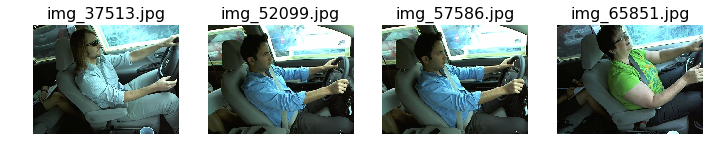

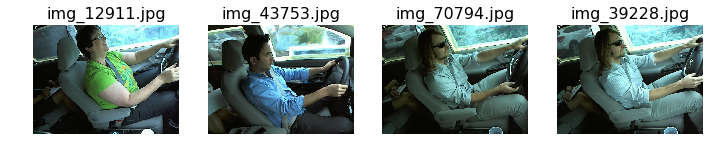

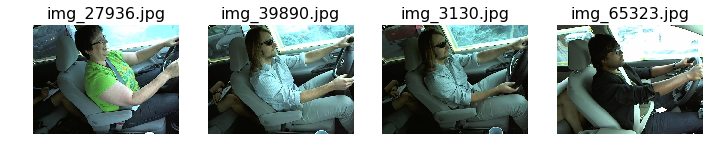

In [440]:
test_idxs = determine_best_pseudo_labels(preds, test_dir, test_filenames, titles, 0, confidence=0.999)

## Next Step, Combine these 8000-odd Pseudo Labeled Data with Training Data

I'm happy with the quality of these predictions, so am moving these best images
to the training folder, in the sub-folder which corresponds to the class prediction.

There is no poing making up a new bcolz array to combine training and pseudo labelled test data because the resulting file will (eventually) become too big for the available memory.

In [442]:
from shutil import move
%cd $DATA_HOME_DIR'test/unknown/'
def move_best_pseudo_to_train(preds, test_dir, test_filenames, titles, confidence=0.995):
    #preds must be a numpy array for the following line to work:
    nrows, ncolumns = preds.shape
    highest_in_classX_idxs = []
    g = glob('*.jpg')
    for i in range(ncolumns):
        """ optional special threshold for one of the classes 
        if i==0:
            threshold = 0.999
        else:
            threshold = confidence 
        idx_to_move = np.where(np.greater(preds[:,i],threshold))[0]
        """
        idx_to_move = np.where(np.greater(preds[:,i],confidence))[0]
        for filename in g:
            if filename in test_filenames[idx_to_move]:
                move(filename, TRAIN_DIR+'c'+str(i)+'/'+filename)
    return

/home/ubuntu/statefarm/test/unknown


In [448]:
test_filenames= np.array(test_filenames)

array(['img_62885.jpg', 'img_45660.jpg', 'img_14645.jpg'],
      dtype='|S14')

In [450]:
len(test_filenames)

60000

In [449]:
move_best_pseudo_to_train(preds, test_dir, test_filenames, titles, confidence=0.995)#damn, I meant to use 0.999

#### Next step is to repeat modelling.  It will involve a two step process as the memory may not be big enough to store all of the images, so ImageGenerator will be required.  Goto file ...phase3.